# Agent Environment Interaction

(taken from Sayama textbook)

The example which will be used to illustrate how this works is the *Keller-Segel Slime Mold Aggregation Model*.  

In this example:
- Slime-mold cells behave as agent.
- These agents interact with an environment made of cAMP molecules. 
- The concentration of cAMP is defined everywhere in the space. 
- It changes by its own inherent dynamics (natural decay) and by action of agents (secretion of cAMP molecules by agents).

The step by step is the following:
1) *Design the data structure to store the attributes of the agents* - if the slime-mold cells are represented by individual agents, their concentration in the original Keller-Segel model is represented by the density of agents, so they will no longer have any attributes other than spatial position in the 2D space. Therefore, x and y are the only attributes of agents in this example.  
2) *Design the data structure to store the states of the environment* - The environment in this model is the spatial function that represents the concentration of cAMP molecules at each location. This environment can be represented by discretising space and assigning a value to each discrete spatial cell.

Below is a sample initialise part that sets up the data structures for both agents and the environment. Note that we prepare two arrays, *env* and *nextenv* for simulating the dynamics of the environment.

In [3]:
n=1000 # number of agents 
w=100 # number of rows/columns in the spatial array 

class agent: # create agent class
    pass 

def initialise():
    global agents, env, nextenv
    
    # initialise the agents
    agents=[]
    for i in range(n):
        ag=agent()
        ag.x=randint(0,w) # for each agent, x is RV between 0 and variable w
        ag.y=randint(0,w) # same for y - allowing us to plot the location of this agent
        
    # initialise the environment - 100x100 array of 0's
    env=zeros([w,w])
    nextenv=zeros([w,w])

3) *Describe the rules for how the environment behaves on its own* - The inherent dynamics of the environment in this model are the diffusion and spontaneous decay of the cAMP concentration. These can be modeled by using the discrete version of the Laplacian operator, as well as an exponential decay factor, applied to the environmental states everywhere in the space in every iteration. We can implement them in the code as follows:

In [4]:
k=1 # rate of cAMP decay
Dc=0.001 # diffusion constant of cAMP
Dh=0.01 # spatial resolution for cAMP simulation
Dt=0.01 # time resolution for cAMP simulation

def Update():
    global agents, env, nextenv
    
    # simulating diffusion and evaporation of cAMP
    for x in range(0,w):
        for y in range(0,w):
            C, R, L, U, D=env[x,y], env[(x+1)%w,y], env[(x-1)%w,y], env[x,(y+1)%w], env[x,(y-1)%w] # centre, right, left, up, down
            lap=(R+L+U+D-4*C)/(Dh**2)
            nextenv[x,y]=env[x,y]+(-k*C*Dc*lap)*Dt
    env, nextenv=nextenv,env

4) *Describe the rules for how agents interact with the environment* - In this model, agents interact with the environment in two ways which I will go through in the next cell.

In [9]:
# 1 - secretion of cAMP by the agents, which can be implemented by letting each agent increase the cAMP concentration in a discrete cell in which it's located

    # add the following to the update function...
    
    # f=1 # rate of cAMP secretion by agents 
    # for ag in agents: 
        # env[ag.x, ag.y]+=f*Dt
        
# 2 - chemotaxis where each agent looks at a cell randomly chosen in its neighbourhood and moves there with a probability determined by the difference in cAMP concentration between the neighbour cell and the cell where the agent is currently located.
# A sigmoid function is suitable for this because P(change in concentration) approaches 1 as change in concentration approaches infinity and approaches 0 and it approaches minus infinity.

# P(change in cAMP concentration) =  e^(change in conc/c_0) / (1+e^(change in conc/c_0))

    # for ag in agents:
        # newx, newy = (ag.x + randint(-1, 2)) % w, (ag.y + randint(-1, 2)) % w
        # diff = (env[newx, newy] - env[ag.x, ag.y]) / 0.1
        # if random() < exp(diff) / (1 + exp(diff)):
            # ag.x, ag.y = newx, newy
            
# NOTE ABOVE: variable diff corresponds to change in concentration and c_0 = 0.1 (c_0 determines how sensitive change in cAMP is to change)

5) *Describe the rules for how agents behave on their own* - In this model, agents only interact with the environment so can skip.

6) *Describe the rules for how agents interact with other agents* - We can skip this step as agents don't interact with eachother directly in this model.

## Entire code is below

In [ ]:
import pycxsimulator
from pylab import *

n = 1000 # number of agents
w = 100 # number of rows/columns in spatial array

k = 1 # rate of cAMP decay
Dc = 0.001 # diffusion constant of cAMP
Dh = 0.01 # spatial resolution for cAMP simulation
Dt = 0.01 # time resolution for cAMP simulation

f = 1 # rate of cAMP secretion by an agent

class agent:
    pass

def initialize():
    global agents, env, nextenv

    agents = []
    for i in range(n):
        ag = agent()
        ag.x = randint(w)
        ag.y = randint(w)
        agents.append(ag)

    env = zeros([w, w])
    nextenv = zeros([w, w])

def observe():
    global agents, env, nextenv
    cla()
    imshow(env, cmap = cm.binary, vmin = 0, vmax = 1)
    axis('image')
    x = [ag.x for ag in agents]
    y = [ag.y for ag in agents]
    plot(y, x, 'b.') # x and y are swapped to match the orientation of env

def update():
    global agents, env, nextenv

    # simulating diffusion and evaporation of cAMP
    for x in range(w):
        for y in range(w):
            C, R, L, U, D = env[x,y], env[(x+1)%w,y], env[(x-1)%w,y], \
                            env[x,(y+1)%w], env[x,(y-1)%w]
            lap = (R + L + U + D - 4 * C) / (Dh**2)
            nextenv[x,y] = env[x,y] + (- k * C + Dc * lap) * Dt
    env, nextenv = nextenv, env

    # simulating secretion of cAMP by agents
    for ag in agents:
        env[ag.x, ag.y] += f * Dt

    # simulating chemotaxis of agents - movement of organism (or part of one) in the direction corresponding to a gradient of increasing or decreasing concentration of a particular substance - in this case, cAMP
    for ag in agents:
        newx, newy = (ag.x + randint(-1, 2)) % w, (ag.y + randint(-1, 2)) % w
        diff = (env[newx, newy] - env[ag.x, ag.y]) / 0.1
        if random() < exp(diff) / (1 + exp(diff)): # if P(change in concentration) > random number between 0 and 1
            ag.x, ag.y = newx, newy

pycxsimulator.GUI().start(func=[initialize, observe, update])

# Result

- For quick results, do 50 steps at a time. 
- Grey-black dots begin to emerge over time and the blue dots (agents) are drawn towards them slowly OR new grey-black dots appear.
- I stopped the simulation after 2000 steps but I would imagine that if left alone, all blue dots would go towards the centre of black circles.

#### Initial state (steps = 0)

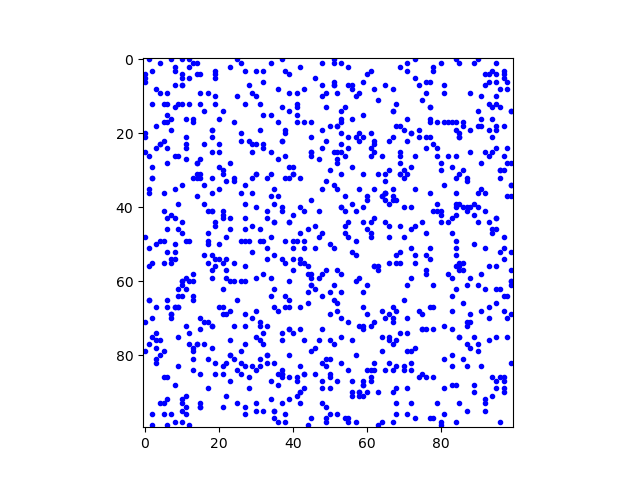

#### Final state (steps = 2000)

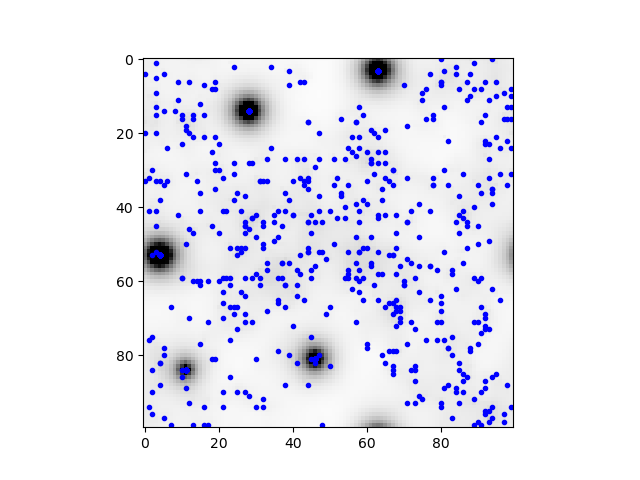